# Idea - change to model.fit() and manually create training data with labels. This function can accept validation splits

In [1]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import numpy as np
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

import os

import matplotlib.pylab as plt
%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla M60 (CNMeM is disabled, cuDNN 5103)
/home/james/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
def ConvBlock(layers, model, filters):
    """
    filters = number of filters
    """
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))  # zero padding of size 1
        model.add(Convolution2D(filters, 3, 3, activation='relu'))  # 3x3 filter size 
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [3]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [4]:
def VGG_16():
    model = Sequential()
#     model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))
#     model.add(Lambda(lambda x : x/255.0, input_shape=(3,64,64)))
    model.add(Lambda(lambda x : x, input_shape=(3,64,64)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1, activation = 'sigmoid'))    
    return model

In [5]:
def show_image(path):
    img = plt.imread(path)
    plt.imshow(img)

In [6]:
train_path = "./train/"
test_path = "./test/"

In [162]:
# optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# optimizer = RMSprop(lr=1e-8)
# optimizer = Adam(lr=1e-4)
optimizer = RMSprop(lr=1e-4)

model = VGG_16()
# model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.compile(loss='binary_crossentropy', optimizer=optimizer,
#               metrics=['accuracy']
             )


/home/james/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_8 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 64, 64)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))
/home/james/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_10_model" was not an Input tensor, it was generated by layer lambda_8.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_10
  str(x.name))


In [12]:
# train_generator = image.ImageDataGenerator().flow_from_directory(
#         train_path,
#         target_size=(64, 64),
#         batch_size=32,
#         shuffle=True,
#         class_mode='categorical')

# hist = model.fit_generator(
#         train_generator,
#         samples_per_epoch=25000/64,
#         nb_epoch = 20

# )

from random import shuffle
from scipy.misc import imresize 

def get_training_data():
    dogs = [train_path+"dogs/"+f for f in os.listdir(train_path+"dogs/")]
    cats = [train_path+"cats/"+f for f in os.listdir(train_path+"cats/")]
    paths = dogs+cats
    shuffle(paths)
    labels = [1 if "dog" in f else 0 for f in paths]
    return paths, labels

def process_train_images(train_paths):
    count = len(train_paths)
    arr = np.zeros(shape=(count,3,64,64))
    
    for c, path in enumerate(train_paths):
        img = plt.imread(path).T
        img = imresize(img,size=(64,64,3),interp="cubic").T
        if c % 250 == 0:
            print("Processing {} of {}".format(c,count))
        arr[c] = img
    return arr

train_paths, y = get_training_data()
train_X = process_train_images(train_paths[:])
train_y = y[:]

# # validation split
# from sklearn.model_selection import train_test_split

# train_X, validation_X, train_y, validation_y = train_test_split(
#      X, y, test_size=0.2, random_state=42)

Processing 0 of 25000
Processing 250 of 25000
Processing 500 of 25000
Processing 750 of 25000
Processing 1000 of 25000
Processing 1250 of 25000
Processing 1500 of 25000
Processing 1750 of 25000
Processing 2000 of 25000
Processing 2250 of 25000
Processing 2500 of 25000
Processing 2750 of 25000
Processing 3000 of 25000
Processing 3250 of 25000
Processing 3500 of 25000
Processing 3750 of 25000
Processing 4000 of 25000
Processing 4250 of 25000
Processing 4500 of 25000
Processing 4750 of 25000
Processing 5000 of 25000
Processing 5250 of 25000
Processing 5500 of 25000
Processing 5750 of 25000
Processing 6000 of 25000
Processing 6250 of 25000
Processing 6500 of 25000
Processing 6750 of 25000
Processing 7000 of 25000
Processing 7250 of 25000
Processing 7500 of 25000
Processing 7750 of 25000
Processing 8000 of 25000
Processing 8250 of 25000
Processing 8500 of 25000
Processing 8750 of 25000
Processing 9000 of 25000
Processing 9250 of 25000
Processing 9500 of 25000
Processing 9750 of 25000
Proces

In [163]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
    
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = LossHistory()

from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)

hist = model.fit(train_X, train_y,
                 batch_size=32, nb_epoch=10,
                 verbose=2,
                 validation_split=0.25, 
                 shuffle=True, 
                 callbacks=[history,checkpointer,early_stopping],
                 initial_epoch=0)

Train on 18750 samples, validate on 6250 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.58330, saving model to /tmp/weights.hdf5
177s - loss: 0.6904 - val_loss: 0.5833
Epoch 2/10
Epoch 00001: val_loss improved from 0.58330 to 0.48165, saving model to /tmp/weights.hdf5
175s - loss: 0.5499 - val_loss: 0.4816
Epoch 3/10
Epoch 00002: val_loss improved from 0.48165 to 0.40768, saving model to /tmp/weights.hdf5
176s - loss: 0.4573 - val_loss: 0.4077
Epoch 4/10
Epoch 00003: val_loss improved from 0.40768 to 0.40325, saving model to /tmp/weights.hdf5
175s - loss: 0.4162 - val_loss: 0.4033
Epoch 5/10
Epoch 00004: val_loss did not improve
165s - loss: 0.3742 - val_loss: 0.4056
Epoch 6/10
Epoch 00005: val_loss improved from 0.40325 to 0.36131, saving model to /tmp/weights.hdf5
177s - loss: 0.3413 - val_loss: 0.3613
Epoch 7/10
Epoch 00006: val_loss did not improve
165s - loss: 0.3215 - val_loss: 0.5739
Epoch 8/10


KeyboardInterrupt: 

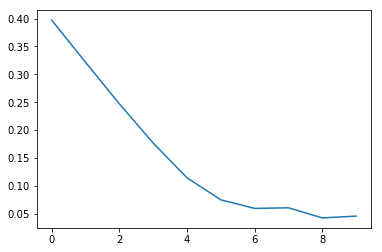

In [17]:
plt.plot(hist.epoch,hist.history['loss'])

In [164]:
from keras.models import load_model

model = load_model('/tmp/weights.hdf5')

/home/james/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py:1811: UserWarning: Model inputs must come from a Keras Input layer, they cannot be the output of a previous non-Input layer. Here, a tensor specified as input to "sequential_11_model" was not an Input tensor, it was generated by layer lambda_8.
Note that input tensors are instantiated via `tensor = Input(shape)`.
The tensor that caused the issue was: lambda_input_11
  str(x.name))


In [18]:
# test_images  = np.array([plt.imread(test[ix]) for ix,path in enumerate(test[:100])])

# pred_generator = predict_generator(
#     test_generator, , max_q_size=10, workers=1, pickle_safe=False, verbose=0)

from scipy.misc import imresize 

def process_test_images(test_paths):
    count = len(test_paths)
    arr = np.zeros(shape=(count,3,64,64))
    
    for c, path in enumerate(test_paths):
        ix = int(path.split("/")[-1].split(".")[0]) - 1
        img = plt.imread(path).T
        img = imresize(img,size=(64,64,3),interp="cubic").T
        if c % 250 == 0:
            print("Processing {} of {}".format(c,count))
        arr[ix] = img
    return arr


test = [test_path+path for path in os.listdir(test_path)]
test_images = process_test_images(test[:])

Processing 0 of 12500
Processing 250 of 12500
Processing 500 of 12500
Processing 750 of 12500
Processing 1000 of 12500
Processing 1250 of 12500
Processing 1500 of 12500
Processing 1750 of 12500
Processing 2000 of 12500
Processing 2250 of 12500
Processing 2500 of 12500
Processing 2750 of 12500
Processing 3000 of 12500
Processing 3250 of 12500
Processing 3500 of 12500
Processing 3750 of 12500
Processing 4000 of 12500
Processing 4250 of 12500
Processing 4500 of 12500
Processing 4750 of 12500
Processing 5000 of 12500
Processing 5250 of 12500
Processing 5500 of 12500
Processing 5750 of 12500
Processing 6000 of 12500
Processing 6250 of 12500
Processing 6500 of 12500
Processing 6750 of 12500
Processing 7000 of 12500
Processing 7250 of 12500
Processing 7500 of 12500
Processing 7750 of 12500
Processing 8000 of 12500
Processing 8250 of 12500
Processing 8500 of 12500
Processing 8750 of 12500
Processing 9000 of 12500
Processing 9250 of 12500
Processing 9500 of 12500
Processing 9750 of 12500
Proces

[[ 0.99873239]]


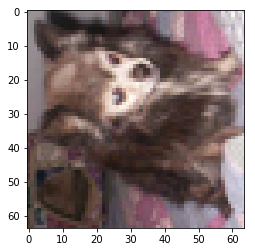

In [141]:
i = 12269
plt.imshow(test_images[i].T/255)
print(model.predict(test_images[i].reshape(1,3,64,64)))

predictions = model.predict(test_images,batch_size=32)

In [19]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=64,
                class_mode='binary',
                target_size=(64,64)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

batches = get_batches(train_path,batch_size=64,target_size=(64,64))

Found 25000 images belonging to 2 classes.


In [168]:
# import pandas as pd

with open("submission_5.csv","w") as f:
    f.write("id,label\n")
    for ix, val in enumerate(predictions):
        f.write("{},{}\n".format(ix+1,val[0]))